## [Anggara Putra Pratama](https://www.dicoding.com/users/anggaraputrapratama)

Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series


Dataset: https://finance.yahoo.com/quote/GOOGL?p=GOOGL&.tsrc=fin-srch

In [1]:
! pip install yfinance

     |████████████████████████████████| 6.4 MB 10.9 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader.data import DataReader

In [3]:
end = datetime(2022, 4, 4)
start = datetime(end.year - 11, end.month, end.day)
stock = yf.download("GOOGL", start, end)

[*********************100%***********************]  1 of 1 completed


In [4]:
stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-04,296.796783,297.667664,291.841827,294.134125,294.134125,4104891
2011-04-05,290.830841,291.036041,283.123108,284.829834,284.829834,12082905
2011-04-06,286.376373,287.867859,284.284271,287.377380,287.377380,5331263
2011-04-07,288.153168,290.610626,287.382385,290.290283,290.290283,5057937
2011-04-08,292.737732,292.737732,289.319305,289.369354,289.369354,3799796
...,...,...,...,...,...,...
2022-03-28,2818.010010,2840.050049,2796.229980,2829.110107,2829.110107,1752500
2022-03-29,2852.949951,2875.870117,2840.770020,2850.110107,2850.110107,1715900
2022-03-30,2849.199951,2854.409912,2832.000000,2838.770020,2838.770020,994200


In [5]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2769 entries, 2011-04-04 to 2022-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2769 non-null   float64
 1   High       2769 non-null   float64
 2   Low        2769 non-null   float64
 3   Close      2769 non-null   float64
 4   Adj Close  2769 non-null   float64
 5   Volume     2769 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 151.4 KB


In [6]:
stock.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

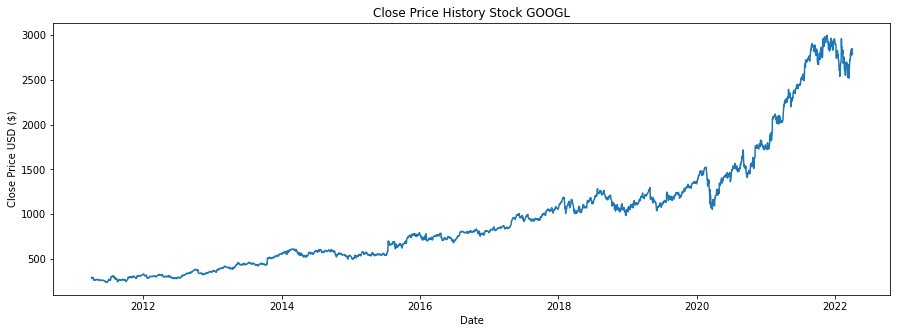

In [7]:
plt.figure(figsize=(15,5))
plt.title('Close Price History Stock GOOGL')
plt.plot(stock['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

In [8]:
data = stock.filter(['Close'])
dataset = data.values

data_train_len = int(np.ceil(len(dataset)* 0.8))

print(data_train_len)

2216


In [9]:

data_train = dataset[:data_train_len]
#data_train = data_train.flatten()
data_test = dataset[data_train_len:]
#data_test = data_test.flatten()


print(data_train.shape)
print(data_test.shape)

(2216, 1)
(553, 1)


In [10]:
skala_data = MinMaxScaler(feature_range=(0,1))
data_train_normalisasi = skala_data.fit_transform(data_train)
data_train_normalisasi = data_train_normalisasi.flatten()

data_test_normalisasi = skala_data.fit_transform(data_test)
data_test_normalisasi = data_test_normalisasi.flatten()

dataset_normalisasi = skala_data.fit_transform(dataset)



In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
train_set = windowed_dataset(data_train_normalisasi, window_size=60, batch_size=100, shuffle_buffer=1000)
validation_set = windowed_dataset(data_test_normalisasi, window_size=60, batch_size=100, shuffle_buffer=1000)

In [13]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(25),
  tf.keras.layers.Dense(1),
])


In [14]:
minMae = (dataset_normalisasi.max() - dataset_normalisasi.min()) * 10/100
minMae

0.09999999999999998

In [15]:
class myEarlyStop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<minMae and logs.get('val_mae')<minMae):
      self.model.stop_training = True

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [16]:

history = model.fit(train_set, validation_data = (validation_set), epochs=100, callbacks=[callback,myEarlyStop()])

Epoch 1/100
22/22 [==============================] - 17s 166ms/step - loss: 0.0647 - mae: 0.2966 - val_loss: 0.0532 - val_mae: 0.2709 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 1s 44ms/step - loss: 0.0235 - mae: 0.1881 - val_loss: 0.0310 - val_mae: 0.2225 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 1s 43ms/step - loss: 0.0247 - mae: 0.1948 - val_loss: 0.0330 - val_mae: 0.2204 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - 1s 39ms/step - loss: 0.0188 - mae: 0.1685 - val_loss: 0.0271 - val_mae: 0.2010 - lr: 0.0010
Epoch 5/100
22/22 [==============================] - 1s 50ms/step - loss: 0.0159 - mae: 0.1554 - val_loss: 0.0224 - val_mae: 0.1831 - lr: 0.0010
Epoch 6/100
22/22 [==============================] - 1s 42ms/step - loss: 0.0135 - mae: 0.1429 - val_loss: 0.0191 - val_mae: 0.1682 - lr: 0.0010
Epoch 7/100
22/22 [==============================] - 1s 42ms/step - loss: 0.0109 - mae: 0.1285 - val_loss: 0.0152 - val_mae: 0.1

In [17]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

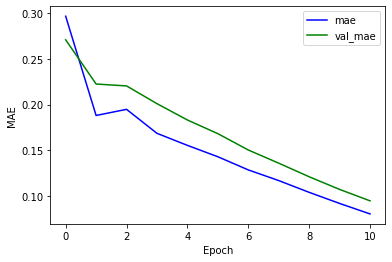

In [18]:
plt.plot(mae, 'b', label='mae')
plt.plot(val_mae, 'g', label='val_mae')

plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

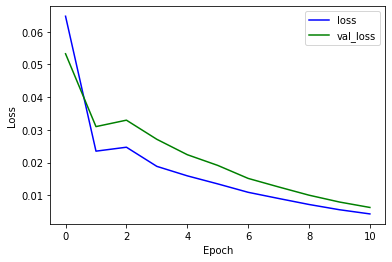

In [19]:
plt.plot(loss, 'b', label='loss')
plt.plot(val_loss, 'g', label='val_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()